Dieses Notebook ist angelehnt an das Buch *Python Data Science Handbook* von Jake VanderPlas, auch verfügbar auf [GitHubPages](https://jakevdp.github.io/PythonDataScienceHandbook/).
Weiter führende Information zu SVM und dem Kernel-Trick finden Sie z.B. im Buch *Understanding Machine Learning - From Theory to Algorithms* von S. Shalev-Schwartz und S. Ben-David, von den Autoren [hier](https://www.cs.huji.ac.il/~shais/UnderstandingMachineLearning/) verfügbar gemacht.

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

# use seaborn plotting defaults
import seaborn as sns; sns.set()

# Support Vector Machines
[Video](https://mstream.hm.edu/paella/ui/watch.html?id=c775c328-a2f3-4efc-8b81-a9bb52ec90c9)

Support Vector Machines (SVMs) sind eine wichtige Klasse von supervised Modellen, die sowohl für **Regression** als auch für **Klassifikation** verwendet werden können.

**Vorteile von SVMs:**
- Sehr kompakte Modelle, d.h. wenn sie trainiert sind, brauchen sie sehr wenig Speicher
- Die Anwendung des Modells ist sehr schnell
- Funktionieren gut mit hochdimensionalen Daten (sogar, wenn die Dimension größer ist als die Anzahl der Trainingspunkte)
- Sehr vielseitig

**Nachteile von SVMs:**
- Training ist aufwändig
- Starke Abhängigkeit von Hyperparametern, insbesondere vom Regularisierungsparameter ``C``
- Interpretierung der Verlässlichkeit schwierig

Wir betrachten hier zur Erläuterung der Funktionsweise nur **Klassifizierung**.

**Ziel der Klassifizierung:** Finde eine (einfache) Kurve (in 2d), Fläche (3d) oder Mannigfaltigkeit (beliebige Dimension), die Punkte verschiedener Klassen voneinander trennt.

Wir betrachten folgendes Beispiel mit zwei Klassen:

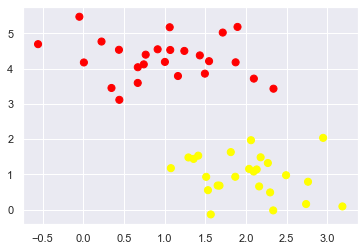

In [2]:
from sklearn.datasets import make_blobs
X, y = make_blobs(n_samples=50, centers=2,
                  random_state=0, cluster_std=0.60)
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn');

Diese beiden Klassen können einfach durch eine gerade Linie getrennt werden. Allerdings ist diese nicht eindeutig:

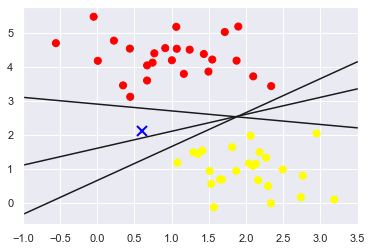

In [3]:
xfit = np.linspace(-1, 3.5)
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')
plt.plot([0.6], [2.1], 'x', color='blue', markeredgewidth=2, markersize=10)

for m, b in [(1, 0.65), (0.5, 1.6), (-0.2, 2.9)]:
    plt.plot(xfit, m * xfit + b, '-k')

plt.xlim(-1, 3.5);

Wenn ein neuer Punkt klassifiziert werden soll, hängt das Ergebnis davon ab, welche der vielen möglichen Geraden gewählt wurde. Da die Wahl also nicht irrelevant ist, sind wir daran interessiert, die "beste" Gerade zu wählen.

## Grundidee: Maximiere die Margin
Die Grundidee bei SVMs ist nun, dass optimalerweise diejenige Gerade gewählt werden sollte, die von beiden Klassen maximal weit entfernt ist.

*Anschaulich: Die Gerade ist der Mittelstreifen der Straße. Die Straße soll möglichst breit sein, ohne dabei die Punkte zu berühren.*

Die "Breite der Straße" wird *Margin* genannt.

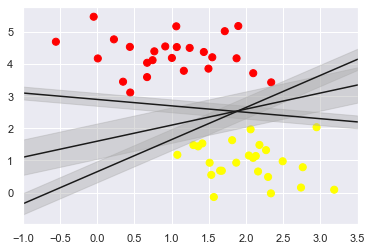

In [4]:
xfit = np.linspace(-1, 3.5)
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')

for m, b, d in [(1, 0.65, 0.33), (0.5, 1.6, 0.55), (-0.2, 2.9, 0.2)]:
    yfit = m * xfit + b
    plt.plot(xfit, yfit, '-k')
    plt.fill_between(xfit, yfit - d, yfit + d, edgecolor='none',
                     color='#AAAAAA', alpha=0.4)

plt.xlim(-1, 3.5);

## Lineare SVM
Support Vector Machines sind in ``sklearn.svm`` vorhanden. Wir betrachten den Classifier ``SVC`` mit den Hyperparametern ``kernel='linear'`` und einem sehr großen ``C``.

*Sneak Preview: Indem man ``kernel`` verändert, kann man nicht-lineare Modelle erzeugen; ``C`` steuert die Regularisierung.*

In [5]:
from sklearn.svm import SVC
model = SVC(kernel='linear', gamma = 'auto', C=1E10)
model.fit(X, y)

SVC(C=10000000000.0, gamma='auto', kernel='linear')

Wir wollen das Ergebnis betrachten. Insbesondere wollen wir die trennende Gerade sehen, aber gerne auch die "Breite der Straße". Dazu dient folgende Funktion:

In [6]:
def plot_svc_decision_function(model, ax=None, plot_support=True, plot_margin=True):
    """Plot the decision function for a 2D SVC"""
    if ax is None:
        ax = plt.gca()
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    
    # create grid to evaluate model
    x = np.linspace(xlim[0], xlim[1], 30)
    y = np.linspace(ylim[0], ylim[1], 30)
    Y, X = np.meshgrid(y, x)
    xy = np.vstack([X.ravel(), Y.ravel()]).T
    P = model.decision_function(xy).reshape(X.shape)
    
    # plot decision boundary and margins
    if plot_margin:
      ax.contour(X, Y, P, colors='k',
                 levels=[-1, 0, 1], alpha=0.5,
                 linestyles=['--', '-', '--'])
    else:
      ax.contour(X, Y, P, colors='k',
                 levels=[0], alpha=0.5,
                 linestyles=['-'])
    
    # plot support vectors
    if plot_support:
        ax.scatter(model.support_vectors_[:, 0],
                   model.support_vectors_[:, 1],
                   s=300, linewidth=1, edgecolors='black', facecolors='none');
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)

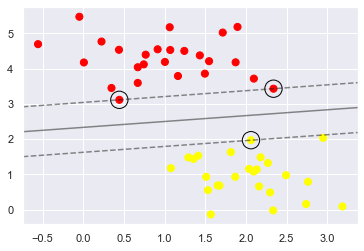

In [7]:
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')
plot_svc_decision_function(model);

Die gefundene Gerade ist diejenige Trenngerade, die die Margin maximiert. Die Trainingspunkte, die die Margin berühren heißen *Support Vectors*.

In [8]:
model.support_vectors_

array([[0.44359863, 3.11530945],
       [2.33812285, 3.43116792],
       [2.06156753, 1.96918596]])

Die Trenngerade hängt nur von diesen ab, d.h. wenn andere Punkte geändert werden oder neu hinzu kommen, ändert sich nichts:

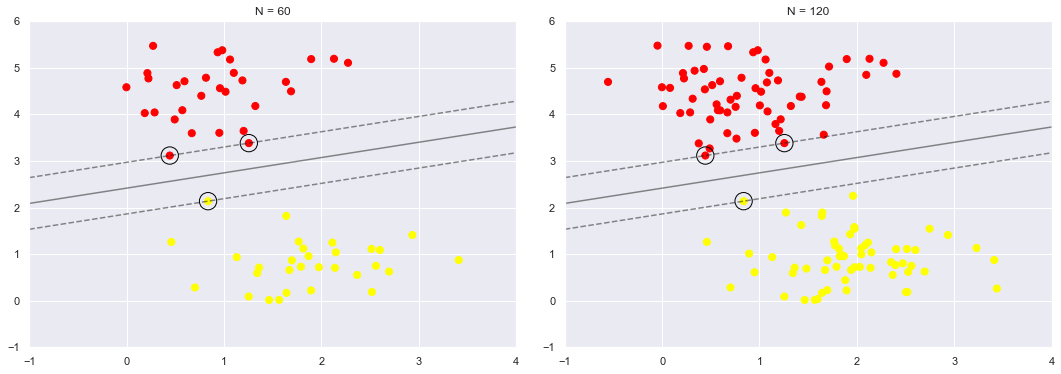

In [9]:
def plot_svm(N=10, ax=None):
    X, y = make_blobs(n_samples=200, centers=2,
                      random_state=0, cluster_std=0.60)
    X = X[:N]
    y = y[:N]
    model = SVC(kernel='linear', C=1E10)
    model.fit(X, y)
    
    ax = ax or plt.gca()
    ax.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')
    ax.set_xlim(-1, 4)
    ax.set_ylim(-1, 6)
    plot_svc_decision_function(model, ax)

fig, ax = plt.subplots(1, 2, figsize=(16, 6))
fig.subplots_adjust(left=0.0625, right=0.95, wspace=0.1)
for axi, N in zip(ax, [60, 120]):
    plot_svm(N, axi)
    axi.set_title('N = {0}'.format(N))

Obwohl das rechte Modell doppelt soviele Trainingspunkte erhalten hat wie das linke, ändert sich am Modell gar nichts. Das Modell scheint also recht stabil zu sein. Konkret: Kommen neue Daten hinzu, die außerhalb der Margin sind, bleibt das Modell gleich.

In [10]:
from ipywidgets import interact, fixed
interact(plot_svm, N=[20, 60, 100, 200, 300], ax=fixed(None));

interactive(children=(Dropdown(description='N', options=(20, 60, 100, 200, 300), value=20), Output()), _dom_cl…

## Nicht-lineare Modelle: Kernel SVMs
Die Idee hinter Kernel-Methoden ist es, die Daten anzureichern, typischerweise auf nicht-lineare Art. Dadurch entstehen neue Features, die Daten werden also höherdimensional. Die Hoffnung ist nun: Wenn man die Daten auf geeignete Art und Weise angereichert hat, kann man sie dann im Höherdimensionalen mit einem linearen Klassifizierer trennen.

Folgende Daten sind offenbar linear nicht trennbar:

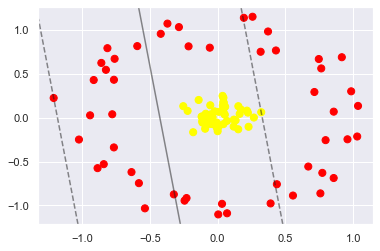

In [13]:
from sklearn.datasets import make_circles
X, y = make_circles(100, factor=.1, noise=.1)

clf = SVC(kernel='linear').fit(X, y)

plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')
plot_svc_decision_function(clf, plot_support=False);

Idee: Man könnte die Daten ins Dreidimensionale bringen und dabei als dritte Komponente den Abstand von der Null einführen. Dadurch würden die gelben Punkte und die roten getrennt:

In [14]:
r = (X ** 2).sum(1)

In [15]:
import plotly.express as px
fig = px.scatter_3d(x=X[:,0], y=X[:,1], z=r, color=y, color_continuous_scale=[[0,'red'],[1,'yellow']])
fig.show()

Natürlich ist das nicht die einzige Möglichkeit. Wie könnten die neue Komponente auch berechnen als
$e^{-(x^2+y^2)}$:

In [16]:
r = np.exp(-(X ** 2).sum(1))
fig = px.scatter_3d(x=X[:,0], y=X[:,1], z=r, color=y,  color_continuous_scale=[[0,'red'],[1,'yellow']])
fig.show()

Durch diese "Anreicherung" werden die Daten nun sehr einfach linear separierbar, z.B. durch eine Ebene bei $r=0.7$.

Der offensichtliche Nachteil ist, dass wir hier sehr genau spezifiziert haben, wie die Daten anzureichern sind. Im Allgemeinen hat man diese Information nicht.

Stattdessen möchte man die Daten "möglichst stark" anreichern, z.B. indem man aus $x_1$ und $x_2$ auch alle Polynome zweiten Grades, also $x_1^2,\ x_1x_2,\ x_2^2$ generiert:

In [17]:
new_features = np.array((X[:,0]**2, X[:,0]*X[:,1],X[:,1]**2)).T
X_poly = np.append(X, new_features, axis=1)
X_poly.shape

(100, 5)

In [18]:
X_poly[0]

array([-0.5806845 , -0.74635674,  0.33719449,  0.43339779,  0.55704838])

Damit können diese Daten nun gelernt werden, denn offenbar kann gelb und rot durch eine Ellipse getrennt werden. Eine beliebige Ellipse lässt sich aber durch $x_1,\ x_2,\ x_1x_2,\ x_1^2,\ x_2^2$ darstellen.

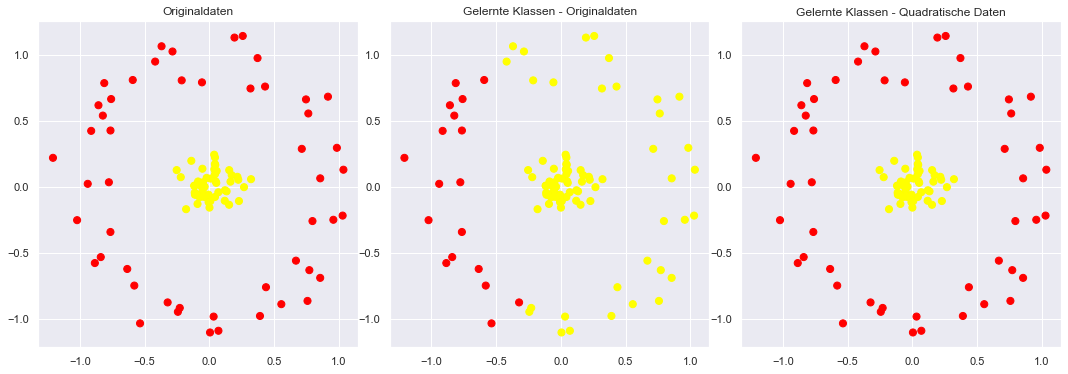

In [19]:
y_lin = clf.predict(X)
clf_poly = SVC(kernel='linear').fit(X_poly,y)
y_poly = clf_poly.predict(X_poly)

fig, ax = plt.subplots(1, 3, figsize=(16, 6))
fig.subplots_adjust(left=0.0625, right=0.95, wspace=0.1)
ax[0].scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')
ax[0].set_title('Originaldaten')
ax[1].scatter(X[:, 0], X[:, 1], c=y_lin, s=50, cmap='autumn')
ax[1].set_title('Gelernte Klassen - Originaldaten')
ax[2].scatter(X[:, 0], X[:, 1], c=y_poly, s=50, cmap='autumn')
ax[2].set_title('Gelernte Klassen - Quadratische Daten');

Insbesondere bei einer hohen Anzahl an Features ergibt sich hier das Problem, dass die Anzahl der "angereicherten Features" SEHR groß sind, insbesondere wenn man Polynome bis zu einem höheren Grad $k$ einbeziehen möchte. Mit solchen sehr hochdimensionalen Daten lässt sich nun nicht mehr sonderlich effizient rechnen. Man bedient sich daher eines "Tricks":

## Der Kern-Trick ("kernel trick")
Es sei $x\in\mathbb{R}^n$ unser (noch nicht angereicherter) Datenpunkt, die (nicht-lineare) "Anreicherung" bezeichnen wir mit $\psi:\mathbb{R}^n\to\mathbb{R}^m$, $m>n$. Somit ist $\psi(x)\in\mathbb{R}^m$ der "angereicherte" Datenpunkt.

Es zeigt sich, dass es für viele ML-Verfahren gar nicht nötig ist, $\psi(x)$ explizit zu betrachten. Vielmehr reicht es aus, die Werte einer sog. *Kern-Funktion* $K(x,x') = \langle \psi(x),\,\psi(x')\rangle$ für alle Kombinationen von $x$ und $x'$ zu kennen. Diese können oft *ohne explizite Kenntnis* von $\psi(x)$ bzw. $\psi(x')$ effizient berechnet werden. Der Wert $K(x,x')$ kann interpretiert werden als Ähnlichkeitsmaß zwischen $x$ und $x'$.

Besonders wichtig (da sehr allgemein einsetzbar) sind:
- Polynomielle Kerne: erzeugen Features bis zu einem gewissen festen Grad
- Gauß Kerne ("RBF", radial basis function): erzeugen polynomielle Features *beliebigen* Grades

Die Abbildung $\psi$, die zum Gauß Kern passt, würde also die Originalfeatures *unendlich* anreichern, $\psi(x)$ liegt in einem *unendlich-dimensionalen* Raum. Ohne den Kern-Trick könnte das natürlich nicht gehandhabt werden.

### Polynomial kernel
Wir verwenden einen polynomiellen Kern (Grad 2) für unsere Daten:

In [20]:
clf_pkernel = SVC(kernel='poly', gamma='auto', degree=2, C=1E6)
clf_pkernel.fit(X,y)

SVC(C=1000000.0, degree=2, gamma='auto', kernel='poly')

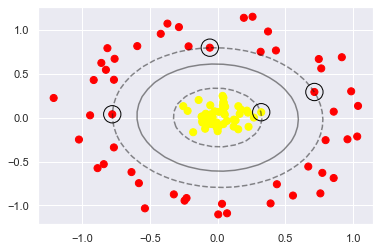

In [21]:
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')
plot_svc_decision_function(clf_pkernel)

### Gaussian kernel
Wir verwenden nun einen Gauss Kern für unsere Daten:

In [22]:
clf_rbfkernel = SVC(kernel='rbf', C=1E6, gamma='auto')
clf_rbfkernel.fit(X,y)

SVC(C=1000000.0, gamma='auto')

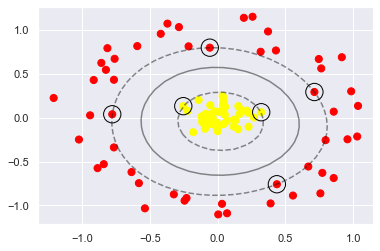

In [23]:
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')
plot_svc_decision_function(clf_rbfkernel)

## Weiteres Beispiel
Betrachten wir noch ein weiteres Datenset, das "schwieriger" zu trennen ist:

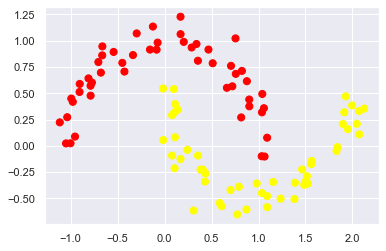

In [25]:
from sklearn.datasets import make_moons
X, y = make_moons(n_samples=100, noise=.1)
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn');

### Linear SVM
Ein lineares Modell kann diese Daten offensichtlich nicht trennen:

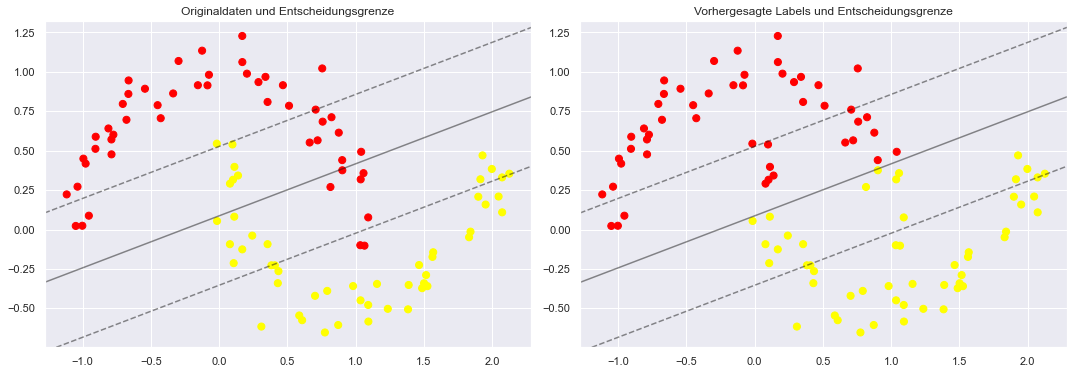

In [26]:
clf = SVC(kernel='linear').fit(X,y)
y_pred = clf.predict(X)

fig, ax = plt.subplots(1, 2, figsize=(16, 6))
fig.subplots_adjust(left=0.0625, right=0.95, wspace=0.1)
ax[0].scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')
plot_svc_decision_function(clf, ax[0], plot_support=False)
ax[0].set_title('Originaldaten und Entscheidungsgrenze')

ax[1].scatter(X[:, 0], X[:, 1], c=y_pred, s=50, cmap='autumn')
plot_svc_decision_function(clf, ax[1], plot_support=False)
ax[1].set_title('Vorhergesagte Labels und Entscheidungsgrenze');

### SVM mit polynomiellem Kern, Grad 2:
Ein quadratisches Modell kann die Daten ebenfalls nicht trennen:

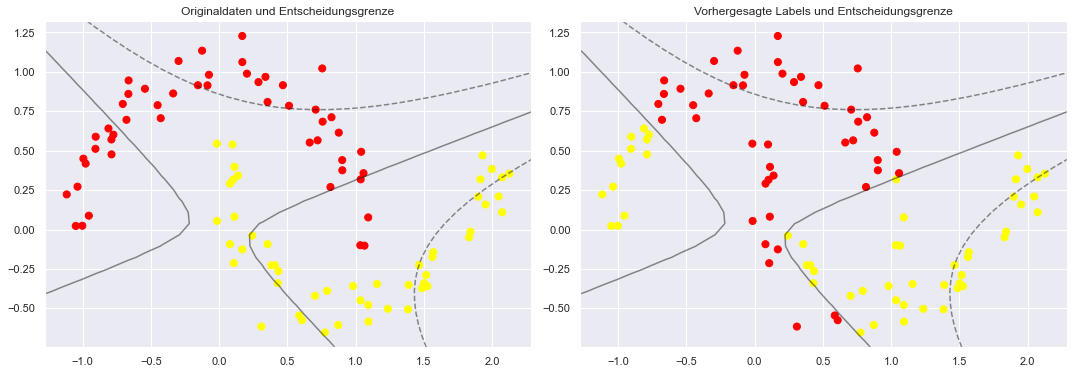

In [27]:
clf = SVC(kernel='poly', degree=2, gamma='auto').fit(X,y)
y_pred = clf.predict(X)
fig, ax = plt.subplots(1, 2, figsize=(16, 6))
fig.subplots_adjust(left=0.0625, right=0.95, wspace=0.1)
ax[0].scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')
plot_svc_decision_function(clf, ax[0], plot_support=False)
ax[0].set_title('Originaldaten und Entscheidungsgrenze')

ax[1].scatter(X[:, 0], X[:, 1], c=y_pred, s=50, cmap='autumn')
plot_svc_decision_function(clf, ax[1], plot_support=False)
ax[1].set_title('Vorhergesagte Labels und Entscheidungsgrenze');

### SVM mit Gauss Kern ("RBF"):
Ein solches Modell ist so mächtig, dass es jeglichen polynomiellen Zusammenhang der Daten abbilden kann. Es kann diese Daten trennen:

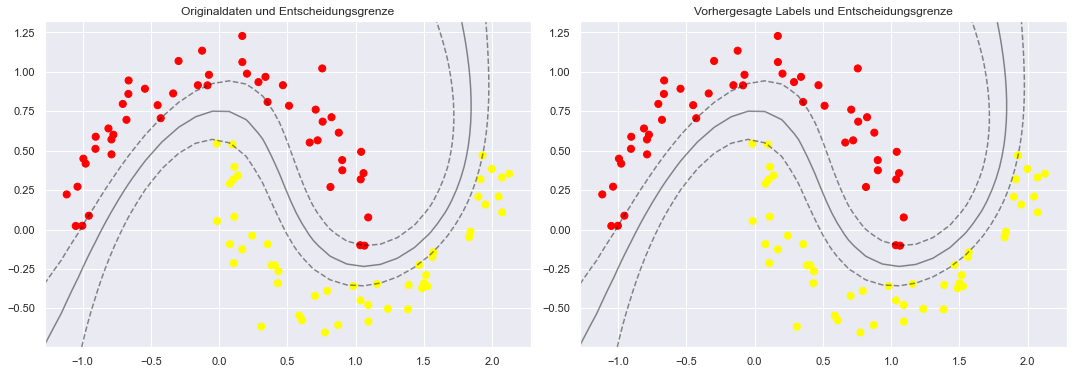

In [28]:
clf = SVC(kernel='rbf', C=1E6, gamma='auto').fit(X,y)
y_pred = clf.predict(X)
fig, ax = plt.subplots(1, 2, figsize=(16, 6))
fig.subplots_adjust(left=0.0625, right=0.95, wspace=0.1)
ax[0].scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')
plot_svc_decision_function(clf, ax[0], plot_support=False)
ax[0].set_title('Originaldaten und Entscheidungsgrenze')

ax[1].scatter(X[:, 0], X[:, 1], c=y_pred, s=50, cmap='autumn')
plot_svc_decision_function(clf, ax[1], plot_support=False)
ax[1].set_title('Vorhergesagte Labels und Entscheidungsgrenze');

## Regularisierung
Die bisher betrachteten Datensets waren sehr "sauber" und damit klar trennbar (wenn auch nicht-linear). Was passiert aber, wenn die Daten verrauscht sind, wenn es Ausreißer gibt?

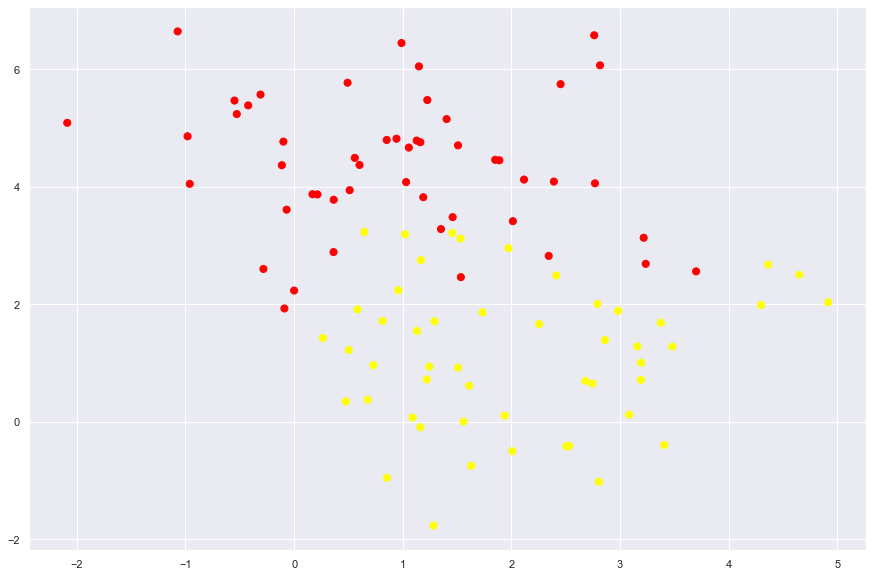

In [29]:
X, y = make_blobs(n_samples=100, centers=2,
                  random_state=0, cluster_std=1.2)
plt.figure(figsize=(15,10))
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn');

Natürlich könnten wir auch hier die gleiche SVM mit RBF Kern verwenden:

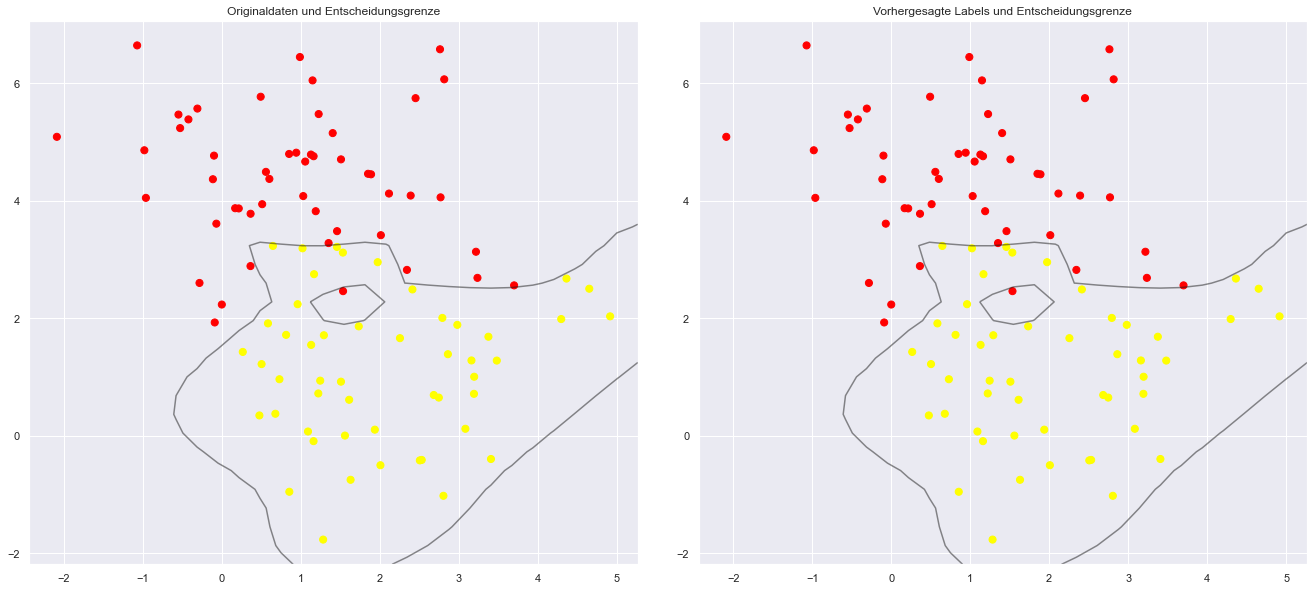

In [30]:
clf = SVC(kernel='rbf', C=1E6, gamma='auto').fit(X,y)
y_pred = clf.predict(X)
fig, ax = plt.subplots(1, 2, figsize=(20, 10))
fig.subplots_adjust(left=0.0625, right=0.95, wspace=0.1)
ax[0].scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')
plot_svc_decision_function(clf, ax[0], plot_support=False, plot_margin=False)
ax[0].set_title('Originaldaten und Entscheidungsgrenze')

ax[1].scatter(X[:, 0], X[:, 1], c=y_pred, s=50, cmap='autumn')
plot_svc_decision_function(clf, ax[1], plot_support=False, plot_margin=False)
ax[1].set_title('Vorhergesagte Labels und Entscheidungsgrenze');

Aber wollen wir das? Ist das ein gutes oder gar das "beste" Ergebnis?

Ziel eines Klassifizierungsmodells ist es, zuerst auf Daten trainiert zu werden (dabei eine Entscheidungsregel zu lernen) und dann für neue Daten vorherzusagen, in welche Klasse sie fallen. Insofern ist es auch hier wichtig, dass das Modell lernt, Ausreißer als solche zu identifizieren und dieses (zufällige oder zumindest mit den vorliegenden Daten nicht erklärbare) Rauschen zu vernachlässigen. Es ist also auch hier wieder **Regularisierung** notwendig.

**Konkret: Nicht jeder einzelne Punkt ist wichtig. Wenn es zu einem wesentlich einfacheren Modell führt, dürfen manche Trainingspunkte ignoriert, d.h. falsch klassifiziert werden.**

SVMs, die das erlauben, nennt man *Soft SVM*, die bisher diskutierten heißen *Hard SVM*. Der Übergang zwischen Soft und Hard SVM ist fließend, er kann in ``sklearn`` durch den Parameter ``C`` geregelt werden:
- kleines ``C``: starke Regularisierung, einzelne Punkte können ignoriert werden
- großes ``C``: schwache Regularisierung, jeder Punkt zählt

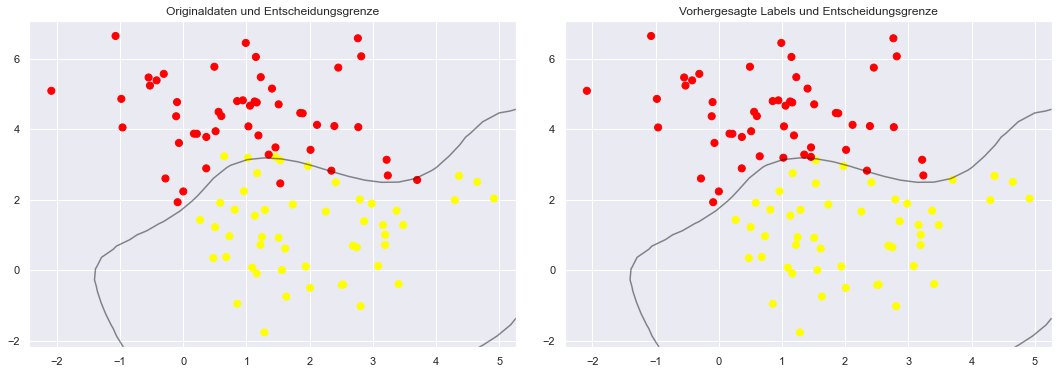

In [31]:
clf = SVC(kernel='rbf', C=1, gamma='auto').fit(X,y)
y_pred = clf.predict(X)
fig, ax = plt.subplots(1, 2, figsize=(16, 6))
fig.subplots_adjust(left=0.0625, right=0.95, wspace=0.1)
ax[0].scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')
plot_svc_decision_function(clf, ax[0], plot_support=False, plot_margin=False)
ax[0].set_title('Originaldaten und Entscheidungsgrenze')

ax[1].scatter(X[:, 0], X[:, 1], c=y_pred, s=50, cmap='autumn')
plot_svc_decision_function(clf, ax[1], plot_support=False, plot_margin=False)
ax[1].set_title('Vorhergesagte Labels und Entscheidungsgrenze');

Die Auswirkung des Regularisierungsparameters ``C`` wird besonders deutlich bei linearen SVMs:

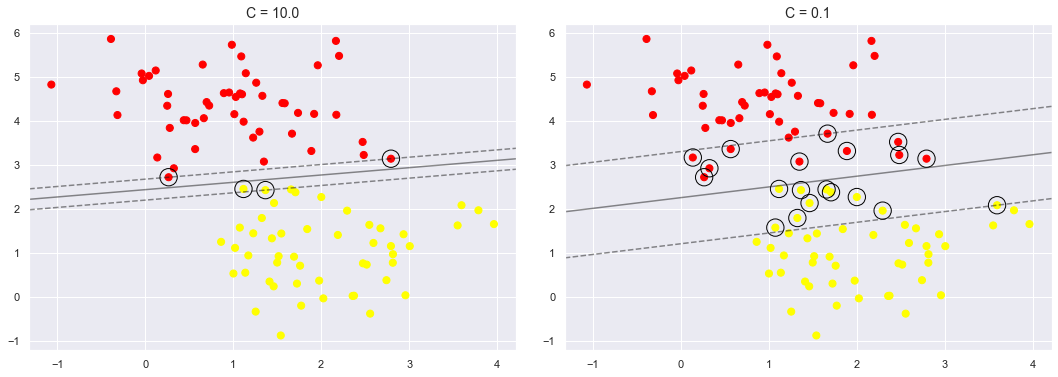

In [32]:
X, y = make_blobs(n_samples=100, centers=2,
                  random_state=0, cluster_std=0.8)

fig, ax = plt.subplots(1, 2, figsize=(16, 6))
fig.subplots_adjust(left=0.0625, right=0.95, wspace=0.1)

for axi, C in zip(ax, [10.0, 0.1]):
    model = SVC(kernel='linear', C=C).fit(X, y)
    axi.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')
    plot_svc_decision_function(model, axi)
    axi.scatter(model.support_vectors_[:, 0],
                model.support_vectors_[:, 1],
                s=300, lw=1, facecolors='none');
    axi.set_title('C = {0:.1f}'.format(C), size=14)

Der optimale Wert für ``C`` hängt stark von den Daten ab (wie viel Rauschen ist vorhanden?) und sollte daher z.B. durch Cross Validation ermittelt werden.

# Anwendungsbeispiel: Gesichtserkennung
Wir verwenden den Beispiel-Datensatz *Labeled faces in the wild*.

In [33]:
from sklearn.datasets import fetch_lfw_people
faces = fetch_lfw_people(min_faces_per_person=60)
print(faces.target_names)
print(faces.images.shape)

['Ariel Sharon' 'Colin Powell' 'Donald Rumsfeld' 'George W Bush'
 'Gerhard Schroeder' 'Hugo Chavez' 'Junichiro Koizumi' 'Tony Blair']
(1348, 62, 47)



Es liegen also 1348 Fotos mit einer Auflösung von 62x47 Pixeln von den genannten acht Personen vor.

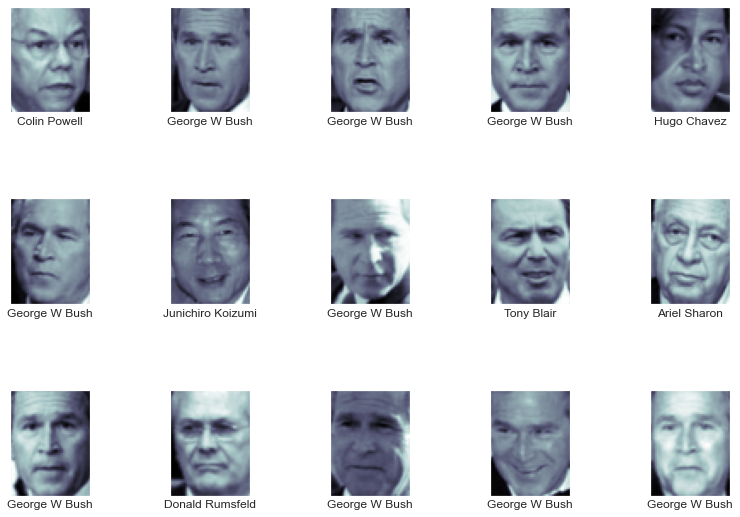

In [34]:
fig, ax = plt.subplots(3, 5, figsize=(10,10))
for i, axi in enumerate(ax.flat):
    axi.imshow(faces.images[i], cmap='bone')
    fig.subplots_adjust(left=0, right=1, wspace=1)
    axi.set(xticks=[], yticks=[],
            xlabel=faces.target_names[faces.target[i]])

Jedes Bild enthält 62x47=2914 Pixel. Wir könnten jeden einzelnen dieser 2914 Pixel als einzelnes Feature verwenden, aber das ist wahrscheinlich gar nicht nötig. Daher verwenden wir Dimensionsreduktion, um z.B. die 150 "wichtigsten" Features zu extrahieren. Basierend auf diesen trainieren wir dann den SVM Classifier.

Für die Dimensionsreduktion verwenden wir PCA. Wir können diese zusammen mit der SVC in eine Pipeline packen:

In [35]:
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline

pca = PCA(n_components=150, svd_solver='randomized', whiten=True, random_state=42)
svc = SVC(kernel='rbf', class_weight='balanced')
model = make_pipeline(pca, svc)

Aufsplitten der Daten in Trainings- und Testdaten:

In [36]:
from sklearn.model_selection import train_test_split
Xtrain, Xtest, ytrain, ytest = train_test_split(faces.data, faces.target,
                                                random_state=42)

Wie oben beschrieben, ist es bei SVM wichtig, den Parameter ``C`` passend zu den Daten zu wählen. Ein weiterer wichtiger Parameter ist ``gamma``, welcher die Form der RBF kontrolliert (großes ``gamma`` bedeutet "enge" RBF, kleines ``gamma`` bedeutet "weite" RBF).

In [37]:
from sklearn.model_selection import GridSearchCV
param_grid = {'svc__C': [1, 5, 10, 50],
              'svc__gamma': [0.0001, 0.0005, 0.001, 0.005]}
grid = GridSearchCV(model, param_grid, cv=3)

%time grid.fit(Xtrain, ytrain)
print(grid.best_params_)

Wall time: 8.72 s
{'svc__C': 5, 'svc__gamma': 0.005}


Damit steht das optimale und auf den vollen Trainingsdaten trainierte Modell in ``grid`` bereit. Wir wenden es auf die Testdaten an:

In [38]:
yfit = grid.predict(Xtest)

Hier ein Teil der vorhergesagten Lables:

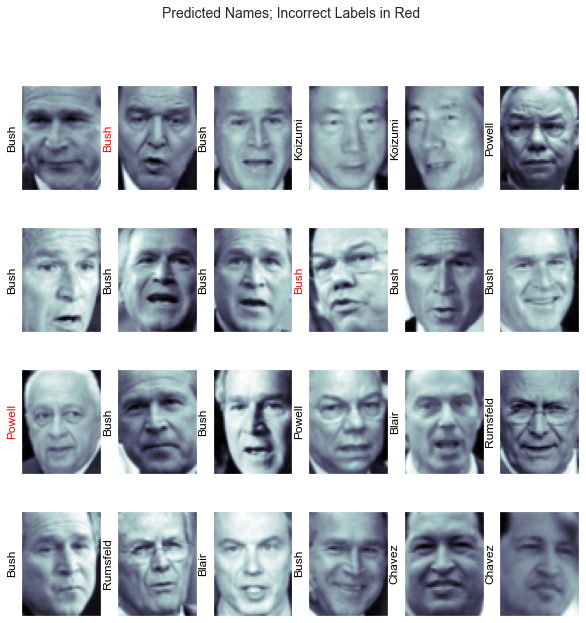

In [39]:
fig, ax = plt.subplots(4, 6, figsize=(10,10))
for i, axi in enumerate(ax.flat):
    axi.imshow(Xtest[i].reshape(62, 47), cmap='bone')
    axi.set(xticks=[], yticks=[])
    axi.set_ylabel(faces.target_names[yfit[i]].split()[-1],
                   color='black' if yfit[i] == ytest[i] else 'red')
fig.suptitle('Predicted Names; Incorrect Labels in Red', size=14);

Genauere Infos liefert z.B. der ``classification_report``:

In [40]:
from sklearn.metrics import classification_report
print(classification_report(ytest, yfit,
                            target_names=faces.target_names))

                   precision    recall  f1-score   support

     Ariel Sharon       0.91      0.67      0.77        15
     Colin Powell       0.85      0.90      0.87        68
  Donald Rumsfeld       0.88      0.74      0.81        31
    George W Bush       0.83      0.94      0.88       126
Gerhard Schroeder       1.00      0.78      0.88        23
      Hugo Chavez       1.00      0.70      0.82        20
Junichiro Koizumi       1.00      0.92      0.96        12
       Tony Blair       0.90      0.90      0.90        42

         accuracy                           0.87       337
        macro avg       0.92      0.82      0.86       337
     weighted avg       0.88      0.87      0.87       337



Was bedeuten diese Werte? Auszug aus der ``sklearn`` Dokumentation:

The precision is the ratio ``tp / (tp + fp)`` where ``tp`` is the number of true positives and ``fp`` the number of false positives. The precision is intuitively the ability of the classifier not to label as positive a sample that is negative.

The recall is the ratio ``tp / (tp + fn)`` where ``tp`` is the number of true positives and ``fn`` the number of false negatives. The recall is intuitively the ability of the classifier to find all the positive samples.

The F-beta score can be interpreted as a weighted harmonic mean of the precision and recall, where an F-beta score reaches its best value at 1 and worst score at 0.

The F-beta score weights recall more than precision by a factor of ``beta``. ``beta == 1.0`` means recall and precision are equally important.

The support is the number of occurrences of each class in ``y_true``.

Eine Bewertung des Modells ist auch durch eine Confusion Matrix möglich:

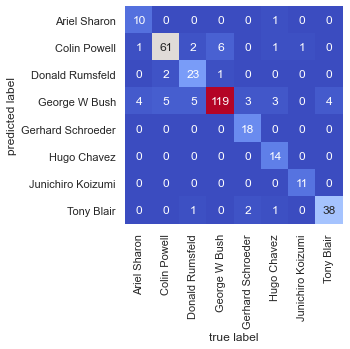

In [41]:
from sklearn.metrics import confusion_matrix
mat = confusion_matrix(ytest, yfit)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False, cmap='coolwarm',
            xticklabels=faces.target_names,
            yticklabels=faces.target_names)
plt.xlabel('true label')
plt.ylabel('predicted label');